# Plot Figure 4

This code plots the joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ PDFs for HR-ERA5/IMERG, LR-ERA5/IMERG, and LR-ERA5/GPCP (Figure 4).

## Import Necessary Packages

In [1]:
import warnings
import numpy as np
import xarray as xr
import proplot as pplt
from calendar import month_name
from matplotlib.lines import Line2D
pplt.rc['tick.minor']=False
warnings.filterwarnings('ignore')

## User-Defined Configurations

Specify the directory where the binned statistics datasets are, and set the directory where the figure will be saved. Specify "monthly pairs" for analysis (i.e., `MONTHPAIRS = [(6,7),(7,8)]` for June-to-July and July-to-August changes). Assign a color to each month for plotting.

In [2]:
FILEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/data/processed'
SAVEDIR      = '/global/cfs/cdirs/m4334/sferrett/monsoon-pod/figs'
MONTHPAIRS   = [(6,7),(7,8)]
COLORS       = {6:'#D42028',7:'#F2C85E',8:'#5BA7DA'}

## Load Binned Statistics Datasets

Load in each binned statistics dataset from `FILEDIR`.

In [3]:
def load(filename,filedir=FILEDIR,varlist=None):
    filepath = f'{filedir}/{filename}'
    ds = xr.open_dataset(filepath)
    if varlist:
        ds = ds[varlist]
    return ds.load()

In [4]:
hrimergstats = load('HR_ERA5_IMERG_binned_stats.nc')
lrimergstats = load('LR_ERA5_IMERG_binned_stats.nc')
lrgpcpstats  = load('LR_ERA5_GPCP_binned_stats.nc')

## Functions for Analysis and Plotting

Here, we use the `get_pdf()` and `get_mode()` functions to calculate the joint $\mathrm{SUBSAT_L}$-$\mathrm{CAPE_L}$ PDF and its mode.

In [5]:
def get_pdf(monthstats,bintype,precipitating=False):
    if bintype=='1D':
        blbins = monthstats.bl.values
        Q0 = monthstats.Q0.values
        QE = monthstats.QE.values
        Q  = QE if precipitating else Q0
        norm = np.nansum(Q0)*np.diff(blbins)[0]
        pdf  = Q/norm
        return xr.DataArray(pdf,coords={'bl':blbins})
    if bintype=='2D':
        subsatbins = monthstats.subsat.values
        capebins   = monthstats.cape.values
        P0 = monthstats.P0.values
        PE = monthstats.PE.values
        P  = PE if precipitating else P0
        norm = np.nansum(P0)*np.diff(subsatbins)[0]*np.diff(capebins)[0]
        pdf  = P/norm
        return xr.DataArray(pdf,coords={'subsat':subsatbins,'cape':capebins})

def get_mode(pdf,bintype):
    if bintype not in ['1D','2D']:
        raise ValueError("Bin type must be '1D' or '2D'")   
    if bintype=='1D':
        blbins   = pdf.bl.values
        maxblidx = np.nanargmax(pdf.values)
        return blbins[maxblidx]
    if bintype=='2D':
        subsatbins = pdf.subsat.values
        capebins   = pdf.cape.values
        maxsubsatidx,maxcapeidx = np.unravel_index(np.nanargmax(pdf.values),pdf.values.shape)
        return subsatbins[maxsubsatidx],capebins[maxcapeidx]

The `create_plot()` function processes the loaded data, performs the required analyses, and generates a formatted figure with results plotted for all three datasets.

In [6]:
def create_plot(statsdict,monthpairs=MONTHPAIRS,colors=COLORS,filename=None):
    statslist = [item[0] for item in statsdict]
    namelist  = [item[1] for item in statsdict]
    fig,axs = pplt.subplots(nrows=len(statslist),ncols=len(statslist[0].region),grid=False,refwidth=1.6,space=0)
    axs.format(rowlabels=namelist,xlabel='$SUBSAT_L$ (K)',xlim=(0,16),ylabel='$CAPE_L$ (K)',ylim=(-6,10))
    for i,stats in enumerate(statslist):
        for j,region in enumerate(stats.region.values):
            ax = axs[i,j]
            ax.format(title=region if i==0 else None,
                      xticks=[2,6,10,14] if i==len(statslist)-1 else None,xtickloc='bottom' if i==len(statslist)-1 else 'neither',
                      yticks=[-4,0,4,8] if j==0 else None,ytickloc='left' if j==0 else 'neither')
            monthpair = monthpairs[0] if j<3 else monthpairs[1]
            handles   = []
            for month in monthpair:
                monthstats = stats.sel(region=region,month=month)
                jointpdf   = get_pdf(monthstats,'2D',precipitating=False)
                pdflevels  = np.arange(np.nanmax(jointpdf)*0.1,np.nanmax(jointpdf),np.nanmax(jointpdf)*0.2)
                subsatmode,capemode = get_mode(jointpdf,'2D')    
                m = ax.contour(jointpdf.T,color=colors[month],levels=pdflevels,alpha=0.7,zorder=0)
                ax.scatter(subsatmode,capemode,color=colors[month],edgecolor='k',marker='*',markersize=100,linewidth=0.5,zorder=1)
                handles.append(Line2D([0],[0],color=colors[month],linewidth=2,label=month_name[month]))
            if i==0 and j in [0,3]:
                ax.legend(handles=handles,loc='ur',ncols=1)
    pplt.show()
    if filename:
        fig.save(f'{SAVEDIR}/{filename}',dpi=900)

## Plot and Save Figure

Execute plotting, and save the figure to `SAVEDIR`.

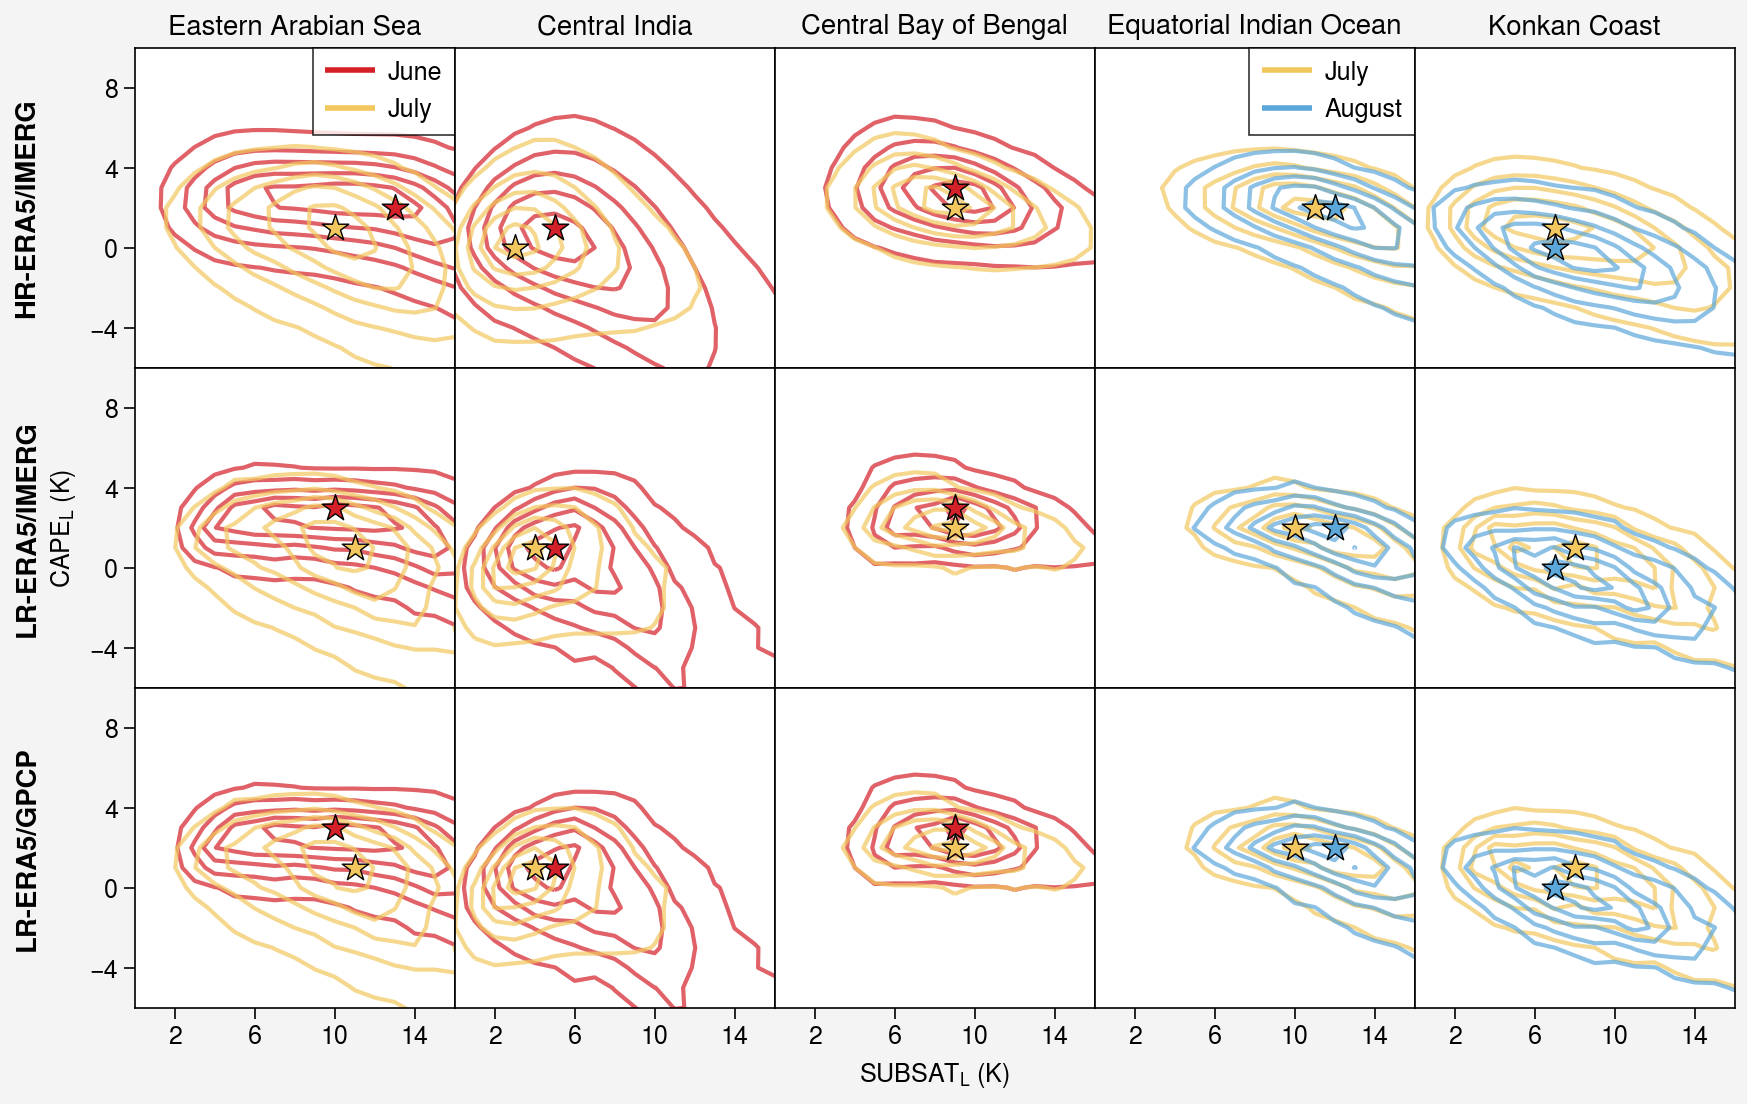

In [8]:
statsdict = [
    (hrimergstats,'HR-ERA5/IMERG'),
    (lrimergstats,'LR-ERA5/IMERG'),
    (lrgpcpstats,'LR-ERA5/GPCP')]
create_plot(statsdict,filename='fig_4.jpg')